#3D IMAGE SEGMENTATION  UNET


In [1]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
#It also segments a large volume and outputs a multidimensional OMETIFF file
#Custom dataset is used for this code but it should work on any dataset, including BRATS.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.9.2
2.9.0


In [5]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!

!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 KB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.8 MB/s eta 0:00:00


In [6]:
#Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.

!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#Make sure GPU is avalable

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print("Found GPU at:{}".format(device_name))

Found GPU at:/device:GPU:0


In [8]:
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [9]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as k
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [10]:
#Load input images and masks. 
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64 for training. 
#"C:\Scaledge\Projects\3D Segmentation using 3D UNET\sandstone_data_for_ML\data_for_3D_Unet\train_images_256_256_256.tif"

image = io.imread('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64,64,64), step = 64)  # Step = 64 for 64 patches means no overlap

mask = io.imread('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64,64,64), step = 64)

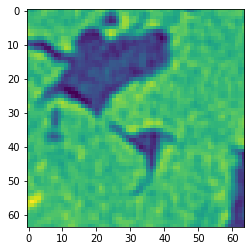

In [11]:
plt.imshow(img_patches[1,2,3,:,:,20]) # change different number to get the corresponding patches like 20,32 etc


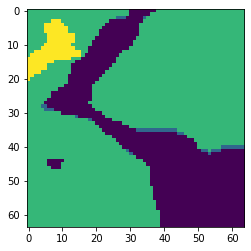

In [12]:
plt.imshow(mask_patches[1,2,3,:,:,32])

In [13]:
print(img_patches.shape) # 256 = 64*4 hence 4,4,4

(4, 4, 4, 64, 64, 64)


In [14]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)   # n_patches, x,y,z

(64, 64, 64, 64)


In [15]:
n_classes = 4 # 4classes - 0->dark area, 1-> grey, 2->scrambles 3->white/bright

In [16]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 

train_img = np.stack((input_img,)*3, axis = -1)
train_mask = np.expand_dims(input_mask, axis =4)

print(input_img.shape)

train_mask_cat = to_categorical(train_mask, num_classes = n_classes)

X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat,test_size = 0.10, random_state=0)

(64, 64, 64, 64)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [17]:
# Define parameters for our model

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'#Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 4
channels = 3
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Loss Function and coefficients to be used during training:
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1* focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold = 0.5), sm.metrics.FScore(threshold = 0.5)]


In [18]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [19]:
#Preprocess input data - otherwise you end up with garbage resutls 
# and potentially model that does not converge.

X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [20]:
from keras.optimizers.optimizer_v1 import Optimizer
#Define the model. Here we use Unet but we can also use other model architectures from the library.

model = sm.Unet(BACKBONE, classes = n_classes,
                input_shape = (patch_size, patch_size, patch_size,channels),
                encoder_weights = encoder_weights,
                activation = activation)

model.compile(optimizer = optim, loss = total_loss, metrics = metrics)
print(model.summary())


176606448/176606448 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                           

In [22]:
# checkpoint
EPOCHS = 10
filepath="/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/weights.best.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_loss',
    verbose=1,
    mode='max',
    save_best_only=True)
callbacks_list = [model_checkpoint]

In [25]:
#Fit the model

data_model = model.fit(X_train_prep,
                    y_train,
                    batch_size = 8,
                    epochs = 100,
                    callbacks=callbacks_list,
                    verbose = 1,
                    validation_data = (X_test_prep, y_test))

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.8514 - iou_score: 0.6566 - f1-score: 0.7638
Epoch 1: val_loss improved from -inf to 0.87431, saving model to /content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/weights.best.hdf5
8/8 [==============================] - 14s 2s/step - loss: 0.8514 - iou_score: 0.6566 - f1-score: 0.7638 - val_loss: 0.8743 - val_iou_score: 0.6552 - val_f1-score: 0.7730
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.8514 - iou_score: 0.6321 - f1-score: 0.7460
Epoch 2: val_loss did not improve from 0.87431
8/8 [==============================] - 13s 2s/step - loss: 0.8514 - iou_score: 0.6321 - f1-score: 0.7460 - val_loss: 0.8681 - val_iou_score: 0.6826 - val_f1-score: 0.7903
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.8493 - iou_score: 0.6435 - f1-score: 0.7479
Epoch 3: val_loss did not improve from 0.87431
8/8 [==============================] - 13s 2s/step - loss: 0.8

In [26]:
# Validation IOU increases from 0.0975 to 0.7045 i.e 9% to 70 to 75%
#Save model for future use
model.save('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/3D_model_vgg16_100epochs.h5')

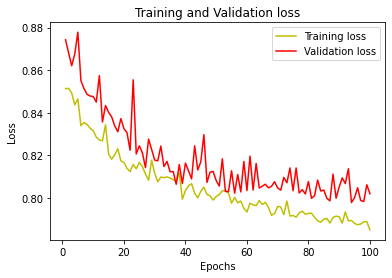

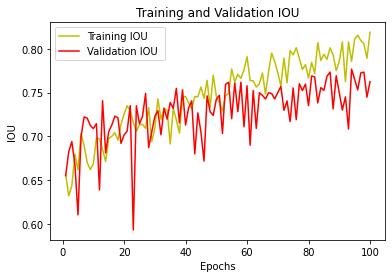

In [27]:
from matplotlib.projections.polar import PolarTransform
#plot the training and validation IoU and loss at each epoch

loss = data_model.history['loss']
val_loss = data_model.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'y', label = 'Training loss')
plt.plot(epochs,val_loss,'r', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = data_model.history['iou_score']
val_acc = data_model.history['val_iou_score']
plt.plot(epochs,acc,'y',label = 'Training IOU')
plt.plot(epochs, val_acc,'r', label = 'Validation IOU ')
plt.title('Training and Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()




In [28]:
#Load the pretrained model for testing and predictions.

from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/3D_model_vgg16_100epochs.h5', compile = False)
#If you load a different model do not forget to preprocess accordingly. 

In [29]:
# Predict on the test data

y_pred = my_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis =4)
y_test_argmax = np.argmax(y_test, axis = 4)

1/1 [==============================] - 0s 497ms/step


In [30]:
print(y_pred_argmax.shape) # 7 images each of 64*64*64
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))


(7, 64, 64, 64)
(7, 64, 64, 64)
[0 2 3]


In [31]:
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.004173624


In [32]:
#Test some random images

import random
test_img_num = random.randint(0, len(X_test))
test_img = X_test[test_img_num]
ground_truth = y_test[test_img_num]

test_img_input = np.expand_dims(test_img,0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis = 4)[0,:,:,:]
print(test_prediction1.shape)

1/1 [==============================] - 1s 748ms/step
(64, 64, 64)


In [33]:
# Look at the ground truth

ground_truth_argmax = np.argmax(ground_truth, axis =3)
print(test_img.shape)

(64, 64, 64, 3)


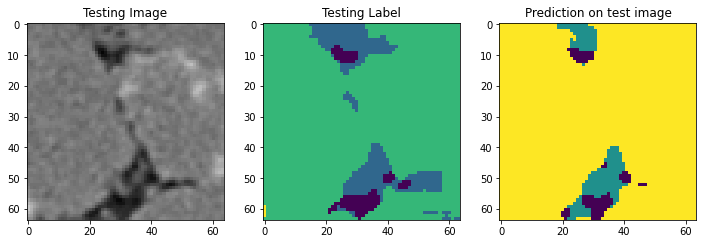

In [34]:
# Plot ground truth versus prediction. Plot individual slices from test predictions for verification

slice = 20
plt.figure(figsize = (12,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

#Now segment the full volume using the trained model.

In [35]:
#Break the large image (volume) into patches of same size as the training images (patches)

large_image = io.imread('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/448_images_512x512.tif') # taken 448 images which is divisible by 64
patches = patchify(large_image,(64,64,64), step = 64) #256 steps for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(448, 512, 512)
(7, 8, 8, 64, 64, 64)


In [36]:
# predict each 3D patch

predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #(print(i,j,k))
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis = -1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis =0))

      single_patch_pred = my_model.predict(single_patch_3ch_input)
      single_patch_pred_argmax = np.argmax(single_patch_pred, axis = 4)[0,:,:,:]

      predicted_patches.append(single_patch_pred_argmax)

1/1 [==============================] - 0s 22ms/step


In [37]:
# Convert list to numpy array

predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


In [38]:
# Reshape to the shape we had after patchifying

predicted_patches_reshaped = np.reshape(predicted_patches,
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                        patches.shape[3], patches.shape[4],patches.shape[5]))
print(predicted_patches_reshaped.shape)

(7, 8, 8, 64, 64, 64)


In [39]:
#Repach individual patches into the original volume shape

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(448, 512, 512)


In [40]:
print(reconstructed_image.dtype)

int64


In [41]:
#int64 image is a huge size and cannot be open, hence we Convert to uint8 so we can open image in most image viewing software packages

reconstructed_image = reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [42]:
# Save the segmented volume of size 448*512*512

from tifffile import imsave, imwrite
imsave('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/segmented.tif', reconstructed_image)

<ipython-input-42-e3ece891a10b>:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/segmented.tif', reconstructed_image)


In [ ]:
#If you would like to save the volume as multichannel dataset....

In [43]:
print(np.unique(reconstructed_image))

[0 1 2 3]


In [44]:
# Separate each channel/segment to be combined as multiple channels

num_segments = 4
seg0 = (reconstructed_image == 0)
seg1 = (reconstructed_image == 1)
seg2 = (reconstructed_image == 2)
seg3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0],reconstructed_image.shape[1],reconstructed_image.shape[2], num_segments ))
final[:,:,:,0] = seg0
final[:,:,:,1] = seg1
final[:,:,:,2] = seg2
final[:,:,:,3] = seg3


In [45]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer-ometiff-library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 KB 17.7 MB/s eta 0:00:00
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2022.10.10
    Uninstalling tifffile-2022.10.10:
      Successfully uninstalled tifffile-2022.10.10


In [46]:
from apeer_ometiff_library import io

In [47]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)

In [48]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)

Shape of the segmented volume is: T, Z, C, X, Y  (1, 448, 4, 512, 512)
int8


In [49]:
from tifffile import imsave, imwrite
imsave('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/segmented_multi_channel.ome.tiff', final)

<ipython-input-49-b1dd88bece9d>:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/data_for_3D_Unet/segmented_multi_channel.ome.tiff', final)


In [52]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
!pip install git+https://github.com/Eothred/h5pyViewer.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Eothred/h5pyViewer.git to /tmp/pip-req-build-qny8vpdd
  Running command git clone --filter=blob:none --quiet https://github.com/Eothred/h5pyViewer.git /tmp/pip-req-build-qny8vpdd
  Resolved https://github.com/Eothred/h5pyViewer.git to commit bba7ad3e1b7cf0896332afb8ebc064fe46ada70f
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5pyViewer
  Running setup.py clean for h5pyViewer
Failed to build h5pyViewer
  Running setup.py install for h5pyViewer ... done
  DEPRECATION: h5pyViewer was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement 

In [62]:
import numpy as np
import h5py
 
# open the file as 'f'
with h5py.File('/content/drive/MyDrive/3D Image Segmentation with 2d UNET/sandstone_data_for_ML/weights.best.hdf5', 'r') as f:
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    print(type(f[a_group_key])) 
    data = list(f[a_group_key])
    #ds_obj = f[a_group_key]      # returns as a h5py dataset object
    #ds_arr = f[a_group_key][()]  # returns as a numpy array

    # get the minimum value
    print(min(data))
     
    # get the maximum value
    print(max(data))
     
    # get the values ranging from index 0 to 15
    print(data[:15])

Keys: <KeysViewHDF5 ['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'center_block1_bn', 'center_block1_conv', 'center_block1_relu', 'center_block2_bn', 'center_block2_conv', 'center_block2_relu', 'decoder_stage0_concat', 'decoder_stage0_upsampling', 'decoder_stage0a_bn', 'decoder_stage0a_conv', 'decoder_stage0a_relu', 'decoder_stage0b_bn', 'decoder_stage0b_conv', 'decoder_stage0b_relu', 'decoder_stage1_concat', 'decoder_stage1_upsampling', 'decoder_stage1a_bn', 'decoder_stage1a_conv', 'decoder_stage1a_relu', 'decoder_stage1b_bn', 'decoder_stage1b_conv', 'decoder_stage1b_relu', 'decoder_stage2_concat', 'decoder_stage2_upsampling', 'decoder_stage2a_bn', 'decoder_stage2a_conv', 'decoder_stage2a_relu', 'decoder_stage2b_bn', 'decoder_stage2b_conv', 'decoder_s